In [ ]:
import pandas as pd
import pickle
from torch import nn
import torch

from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import torchaudio
import os

# Scores and reports
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve


Mounted at /content/drive


In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

DROP_OUT = 0.5



class Convolutional_Speaker_Identification(nn.Module):

    # def cal_paddind_shape(self, new_shape, old_shape, kernel_size, stride_size):
    #     return (stride_size * (new_shape - 1) + kernel_size - old_shape) / 2

    def __init__(self):

        super().__init__()

        self.conv_2d_1 = nn.Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.bn_1 = nn.BatchNorm2d(96)
        self.max_pool_2d_1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))

        self.conv_2d_2 = nn.Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.bn_2 = nn.BatchNorm2d(256)
        self.max_pool_2d_2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        self.conv_2d_3 = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1)
        self.bn_3 = nn.BatchNorm2d(384)

        self.conv_2d_4 = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1)
        self.bn_4 = nn.BatchNorm2d(256)

        self.conv_2d_5 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.bn_5 = nn.BatchNorm2d(256)
        self.max_pool_2d_3 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))

        self.conv_2d_6 = nn.Conv2d(256, 4096, kernel_size=(9, 1), padding=0)
        self.drop_1 = nn.Dropout(p=DROP_OUT)

        self.global_avg_pooling_2d = nn.AdaptiveAvgPool2d((1, 1))
        self.dense_1 = nn.Linear(4096, 1024)
        self.drop_2 = nn.Dropout(p=DROP_OUT)

        self.dense_2 = nn.Linear(1024, 3)

    def forward(self, X):

        x = nn.ReLU()(self.conv_2d_1(X))
        x = self.bn_1(x)
        x = self.max_pool_2d_1(x)

        x = nn.ReLU()(self.conv_2d_2(x))
        x = self.bn_2(x)
        x = self.max_pool_2d_2(x)

        x = nn.ReLU()(self.conv_2d_3(x))
        x = self.bn_3(x)

        x = nn.ReLU()(self.conv_2d_4(x))
        x = self.bn_4(x)

        x = nn.ReLU()(self.conv_2d_5(x))
        x = self.bn_5(x)
        x = self.max_pool_2d_3(x)

        x = nn.ReLU()(self.conv_2d_6(x))
        x = self.drop_1(x)
        x = self.global_avg_pooling_2d(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer
        x = nn.ReLU()(self.dense_1(x))
        x = self.drop_2(x)

        x = self.dense_2(x)
        y = nn.LogSoftmax(dim=1)(x)   # consider using Log-Softmax

        return y

    def get_epochs(self):
        return 20

    def get_learning_rate(self):
        return 0.000005

    def get_batch_size(self):
        return 16

    def to_string(self):
        return "Convolutional_Speaker_Identification_Log_Softmax_Model-epoch_"

# Load x and y:

In [ ]:
def load_x(llen):

  x_to_add1 = open("/content/drive/MyDrive/voice/"+llen+"_x_test.pickle","rb")
  x_test = pickle.load(x_to_add1)
  x_to_add1.close()

  my_tensor = torch.cat(x_test)
  my_tensor = torch.unsqueeze(my_tensor, 1)

  return my_tensor




def load_y(llen, lan_dict):

  pickle_in_y1 = open("/content/drive/MyDrive/voice/"+llen+"_y_test.pickle","rb")
  y_test = pickle.load(pickle_in_y1)
  pickle_in_y1.close()

  temp_dickt = lan_dict 

  y_test_num = torch.FloatTensor([temp_dickt[x] for x in y_test])
  print(temp_dickt)
  return y_test_num








# English scoring: 66 %

{'us_en': 0, 'england_en': 1, 'canada_en': 2}

en Test accuracy score: 65.57 %
 Classification Report
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       142
           1       0.69      0.77      0.73       150
           2       0.58      0.34      0.43        74

    accuracy                           0.66       366
   macro avg       0.64      0.60      0.61       366
weighted avg       0.65      0.66      0.64       366



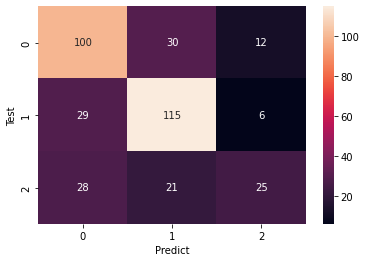

In [ ]:
# Test accuracy score: 62.84 % with 2 more liars
lan = 'en';
lan_dict = {'us_en': 0, 'england_en': 1, 'canada_en': 2}
model = Convolutional_Speaker_Identification().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/voice/models/"+lan+"stat0.pth"))
model.eval()
x = load_x(lan)
y = load_y(lan, lan_dict)


print()

y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))
print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()



# Ca scoring: 58.28 %

{'balearic_ca': 0, 'central_ca': 1, 'valencian_ca': 2}

ca Test accuracy score: 58.28 %
 Classification Report
              precision    recall  f1-score   support

           0       0.58      0.30      0.39        84
           1       0.55      0.58      0.56       179
           2       0.61      0.72      0.66       190

    accuracy                           0.58       453
   macro avg       0.58      0.53      0.54       453
weighted avg       0.58      0.58      0.57       453



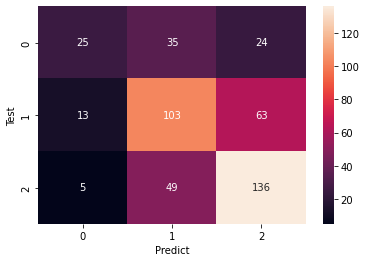

In [ ]:
# Test accuracy score: 52.01 %
lan = 'ca';
lan_dict = {'balearic_ca': 0, 'central_ca': 1, 'valencian_ca': 2}
model = Convolutional_Speaker_Identification().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/voice/models/"+lan+"stat0.pth"))
model.eval()
x = load_x(lan)
y = load_y(lan, lan_dict)


print()

y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))
print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()



# Fr scoring: 51.3 %


{'switzerland_fr': 0, 'france_fr': 1, 'belgium_fr': 2}
fr Test accuracy score: 51.32 %
 Classification Report
              precision    recall  f1-score   support

           0       0.54      0.13      0.22        52
           1       0.56      0.75      0.64        99
           2       0.43      0.47      0.45        77

    accuracy                           0.51       228
   macro avg       0.51      0.45      0.44       228
weighted avg       0.51      0.51      0.48       228



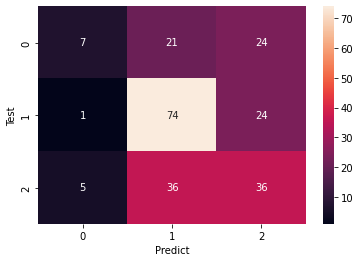

In [ ]:
# Test accuracy score: 50.4 % with 2 more liars
lan = 'fr';
model = torch.load("/content/drive/MyDrive/voice/models/"+lan+"model1.pth")
lan_dict = {'switzerland_fr': 0, 'france_fr': 1, 'belgium_fr': 2}

model.eval()
x = load_x("test_data/"+lan)
y = load_y("test_data/"+lan, lan_dict)


y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()



# Eu scoring: 76 %

{'mendebalekoa_eu': 0, 'erdialdekoa_nafarra_eu': 1}
eu Test accuracy score: 75.68 %
 Classification Report
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       171
           1       0.76      0.80      0.78       195

    accuracy                           0.76       366
   macro avg       0.76      0.75      0.75       366
weighted avg       0.76      0.76      0.76       366



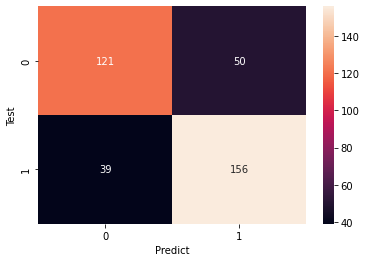

In [ ]:
# Test accuracy score: 72.95 %
lan = 'eu';
model = torch.load("/content/drive/MyDrive/voice/models/"+lan+"model0.pth")
lan_dict = {'mendebalekoa_eu': 0, 'erdialdekoa_nafarra_eu': 1}

model.eval()
x = load_x(lan)
y = load_y(lan, lan_dict)


y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

# zh scoring: 66 %

{'440000_zh-CN': 0, '330000_zh-CN': 1, '110000_zh-CN': 2}
zh-cn Test accuracy score: 65.73 %
 Classification Report
              precision    recall  f1-score   support

           0       0.66      0.21      0.32        90
           1       0.63      0.68      0.66       213
           2       0.68      0.81      0.74       231

    accuracy                           0.66       534
   macro avg       0.66      0.57      0.57       534
weighted avg       0.66      0.66      0.63       534



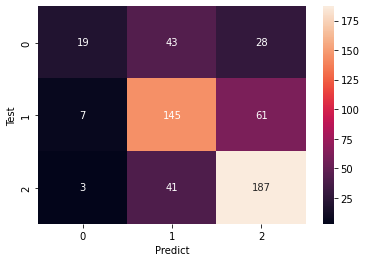

In [ ]:
# Test accuracy score: 60.06 %
lan = 'zh-cn';
model = torch.load("/content/drive/MyDrive/voice/models/"+lan+"model3.pth")
lan_dict = {'440000_zh-CN': 0, '330000_zh-CN': 1, '110000_zh-CN': 2}

model.eval()
x = load_x("test_data/"+lan)
y = load_y("test_data/"+lan, lan_dict)


y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

# Es scoring: 65 %

{'nortepeninsular_es': 1, 'chileno_es': 2, 'andino_es': 0}
es Test accuracy score: 64.66 %
 Classification Report
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       164
           1       0.58      0.68      0.63       122
           2       0.51      0.45      0.48        62

    accuracy                           0.65       348
   macro avg       0.62      0.61      0.61       348
weighted avg       0.65      0.65      0.65       348



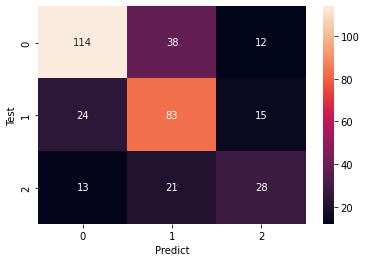

In [ ]:
lan = 'es';
model = torch.load("/content/drive/MyDrive/voice/models/"+lan+"model0.pth")
lan_dict = {'nortepeninsular_es': 1, 'chileno_es': 2, 'andino_es': 0}

model.eval()
x = load_x("test_data/"+lan)
y = load_y("test_data/"+lan, lan_dict)


y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

# De scoring: 50.0 %

{'germany_de': 0, 'austria_de': 1, 'switzerland_de': 2}
de Test accuracy score: 50.24 %
 Classification Report
              precision    recall  f1-score   support

           0       0.47      0.62      0.53       152
           1       0.53      0.52      0.53       166
           2       0.53      0.30      0.38       104

    accuracy                           0.50       422
   macro avg       0.51      0.48      0.48       422
weighted avg       0.51      0.50      0.49       422



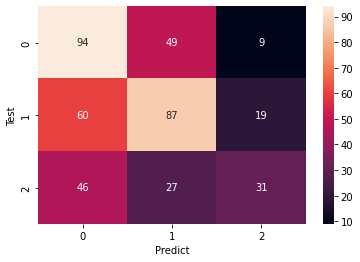

In [ ]:

lan = 'de';
model = torch.load("/content/drive/MyDrive/voice/models/"+lan+"model3.pth")
lan_dict = {'germany_de': 0, 'austria_de': 1, 'switzerland_de': 2}

model.eval()
x = load_x("test_data/"+lan)
y = load_y("test_data/"+lan, lan_dict)


y_p = np.argmax(model(x.to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y, dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print(lan + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

# language scoring: 82.0 %

{'eu': 0, 'de': 1, 'es': 2, 'ca': 3, 'fr': 4, 'zh-CN': 5, 'en': 6}
lan Test accuracy score: 81.6 %
 Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        83
           1       0.77      0.67      0.72        55
           2       0.78      0.64      0.70        55
           3       0.75      0.58      0.66        67
           4       0.69      0.87      0.77        52
           5       0.81      0.97      0.88       105
           6       0.98      0.96      0.97        83

    accuracy                           0.82       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.82      0.82      0.81       500



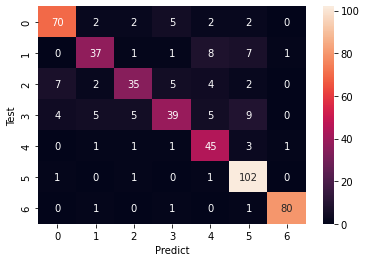

In [ ]:

model = torch.load("/content/drive/MyDrive/1_new/model/enmodel0.pth")
temp_dickt = {'eu': 0, 'de': 1, 'es': 2, 'ca': 3, 'fr': 4, 'zh-CN': 5, 'en': 6}

model.eval()



# load x
x_to_add1 = open("/content/drive/MyDrive/1_new/law/all_x_test.pickle","rb")
x_test = pickle.load(x_to_add1)
x_to_add1.close()
my_tensor = torch.cat(x_test)
x = torch.unsqueeze(my_tensor, 1)

# load y
pickle_in_y1 = open("/content/drive/MyDrive/1_new/law/all_y_test.pickle","rb")
y_test = pickle.load(pickle_in_y1)
pickle_in_y1.close()
temp_dickt = temp_dickt 
y = torch.FloatTensor([temp_dickt[x] for x in y_test])
print(temp_dickt)





y_p = np.argmax(model(x[:500].to(device)).to("cpu").detach().numpy(), axis =1)
y_true = np.array(y[:500], dtype= int)

acc = np.mean(np.array(y_p == y_true, dtype= int))



print("lan" + " Test accuracy score:", round(acc*100,2) , "%")

print(' Classification Report')
print(classification_report(y_true, y_p))

cm = confusion_matrix(y_true, y_p)
plt.subplots()
sns.heatmap(cm,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()



		en



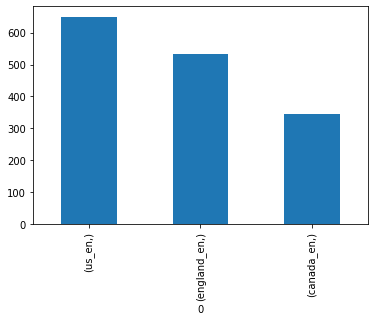



		ca



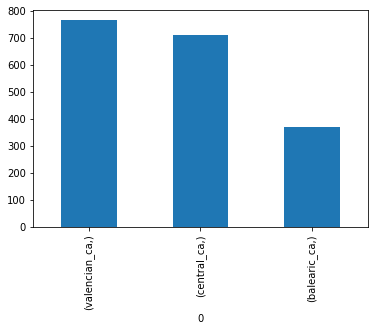



		fr



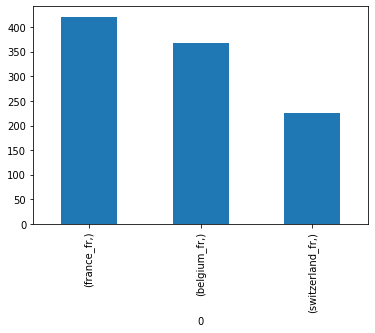



		eu



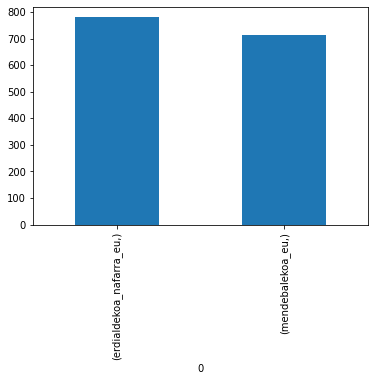



		zh-cn



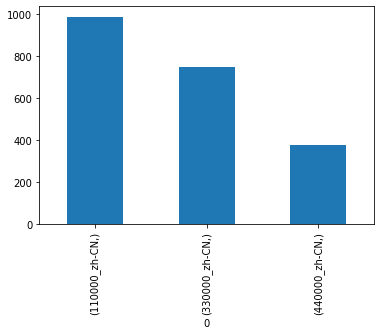



		es



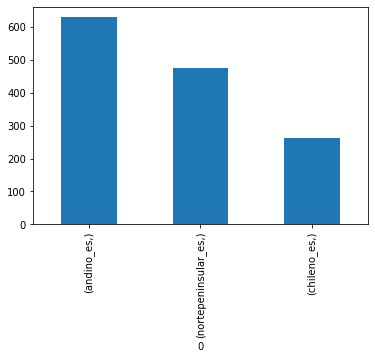



		de



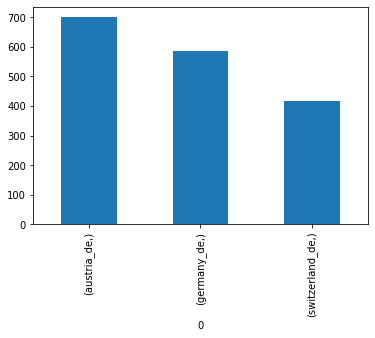

In [ ]:
to_delete = ["france_de", "canada_de","centrosurpeninsular_es", "canada_fr", "450000_zh-CN"]
for lan in ["en" , "ca", "fr", "eu", "zh-cn", "es", "de"]:
  pickle_in_y12 = open("/content/drive/MyDrive/voice/"+lan+"_y_train.pickle","rb")
  y_test = pickle.load(pickle_in_y12)
  pickle_in_y12.close()
  print("\n\n\t\t"+ lan + "\n")
  df_to_plot = pd.DataFrame(y_test)
  df_to_plot[~df_to_plot[0].isin(to_delete)].value_counts().plot.bar()
  plt.show()
